In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
#build the dataset
block_size = 3 # context length

def build_dataset(words):
    X, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [64]:
n_embd = 10 # the dimensionality of character embedding vector
n_hidden = 200 # the number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)#* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [65]:
max_steps = 200000
batch_size = 32
lossi = []

for iter in range(max_steps):

    #minibatch construct
    idx = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, yb = X_train[idx], y_train[idx]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the context vectors
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias


    with torch.no_grad():
      bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
      bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # log of counts (analogous to counts in bigram)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), y].log().mean()
    loss = F.cross_entropy(logits, yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr = lrs[iter]
    lr = 0.1 if iter < 100000 else 0.01 # lr decay
    for p in parameters:
        p.data += -lr * p.grad


    if iter%10000 == 0:
      print(f'{iter:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

    #break

      0/ 200000:  3.3239
  10000/ 200000:  2.0322
  20000/ 200000:  2.5675
  30000/ 200000:  2.0125
  40000/ 200000:  2.2446
  50000/ 200000:  1.8897
  60000/ 200000:  2.0785
  70000/ 200000:  2.3681
  80000/ 200000:  2.2918
  90000/ 200000:  2.0238
 100000/ 200000:  2.3673
 110000/ 200000:  2.3132
 120000/ 200000:  1.6414
 130000/ 200000:  1.9311
 140000/ 200000:  2.2231
 150000/ 200000:  2.0027
 160000/ 200000:  2.0997
 170000/ 200000:  2.4949
 180000/ 200000:  2.0199
 190000/ 200000:  2.1707


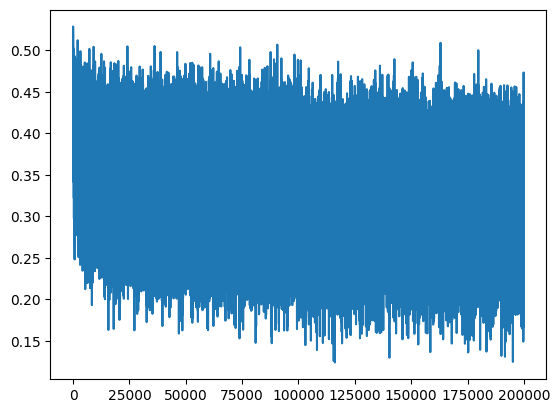

In [60]:
plt.plot(lossi)

In [56]:
# calibrate batch norm at the end of training

with torch.no_grad():
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(dim=0, keepdim=True)
  bnstd = hpreact.std(dim=0, keepdim=True)

In [61]:
@torch.no_grad() # a decorator that disable gradient tracking

def split_loss(s, X, y):
  emb = C[X]
  embcat = emb.view(emb.shape[0], -1) # concatenate the context vectors
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * ((hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)) + bnbias
  hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 # log of counts (analogous to counts in bigram)
  loss = F.cross_entropy(logits, y)
  print(s, loss.item())

split_loss('train', X_train, y_train)
split_loss('dev', X_dev, y_dev)

train 2.06659197807312
dev 2.10505747795105


In [45]:
g = torch.Generator().manual_seed(2147483647 + 6)

for i in range(20):
    out = []
    context = [0]*block_size #initialize with all ...
    while True:
        emb = C[torch.tensor([context])] #(1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [idx]
        if idx == 0:
            break
        out.append(itos[idx])
    print(''.join(ch for ch in out))

arifensa
brohan
kere
paysen
allin
arie
deem
led
card
zaysa
den
onor
nakiyah
alveronatildigelus
billandra
ain
ten
mckayleen
owenaini
elly


tensor(-0.0121) tensor(1.0036)
tensor(0.0009) tensor(1.0299)


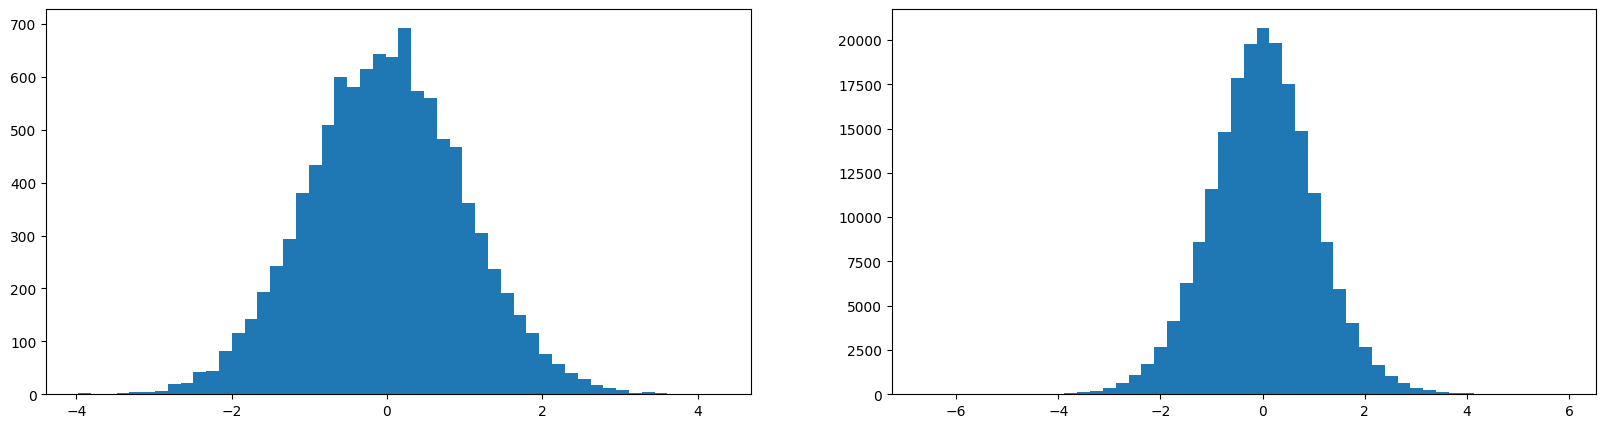

In [37]:
x = torch.randn(1000, 10)
W = torch.randn(10, 200) / 10**0.5
y = x @ W
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).numpy(), 50);
plt.subplot(122)
plt.hist(y.view(-1).numpy(), 50);

In [53]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    #calculate the forward pass
    if self.training:
      xmean = x.mean(dim=0, keepdim=True)
      xvar = x.var(dim=0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    #update buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of character embedding vector
n_hidden = 100 # the number of neurons in the hidden layer of mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  #last layer: make it less confident
  layers[-1].gamma *= 0.1
  # for all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47551


In [54]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for iter in range(max_steps):

    #minibatch construct
    idx = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, yb = X_train[idx], y_train[idx]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the context vectors
    for layer in layers:
      x = layer(x)
    loss = F.cross_entropy(x, yb)


    #backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if iter < 100000 else 0.01 # lr decay
    for p in parameters:
        p.data += -lr * p.grad


    if iter%10000 == 0:
      print(f'{iter:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if iter >= 1000:
      break

      0/ 200000:  3.2870


layer 2 (      Tanh): mean -0.00, std 0.63 saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64 saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64 saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65 saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65 saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

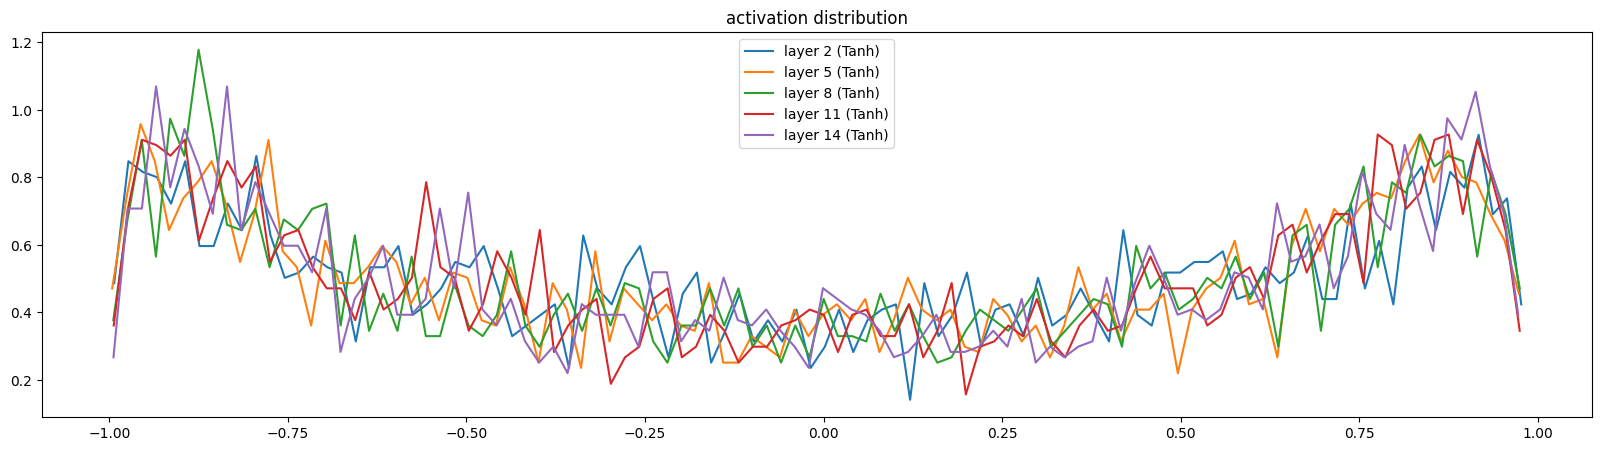

In [55]:
plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.682961e-03
layer 5 (      Tanh): mean -0.000000, std 3.262612e-03
layer 8 (      Tanh): mean +0.000000, std 2.973734e-03
layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584295e-03


Text(0.5, 1.0, 'gradient distribution')

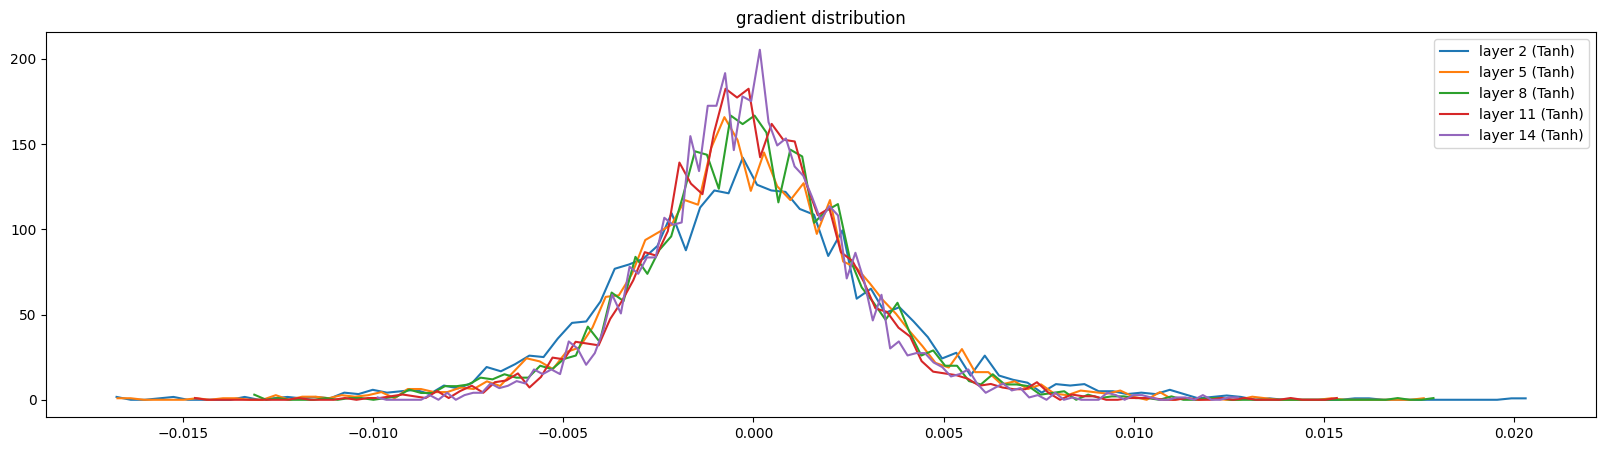

In [56]:
plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019890e-02 | grad:data ration 1.018851e-02
weight  (30, 100) | mean +0.000092 | std 8.238448e-03 | grad:data ration 2.635845e-02
weight (100, 100) | mean +0.000031 | std 7.318127e-03 | grad:data ration 4.377153e-02
weight (100, 100) | mean -0.000019 | std 6.662029e-03 | grad:data ration 3.949899e-02
weight (100, 100) | mean -0.000019 | std 5.821521e-03 | grad:data ration 3.468164e-02
weight (100, 100) | mean +0.000053 | std 5.445303e-03 | grad:data ration 3.243371e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ration 6.281275e-02


Text(0.5, 1.0, 'weights gradient distribution')

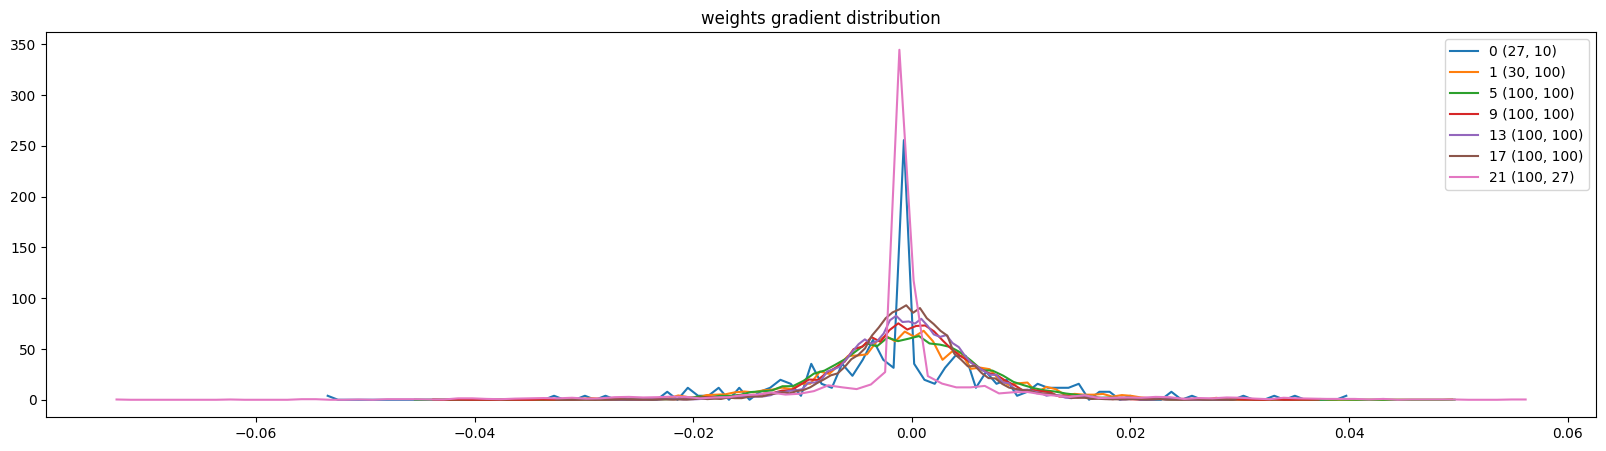

In [57]:
plt.figure(figsize=(20, 5))
legends = []
for i, p in enumerate(parameters): # note: exclude output layer
    t = p.grad
    if p.ndim == 2:
      print('weight %10s | mean %+f | std %e | grad:data ration %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

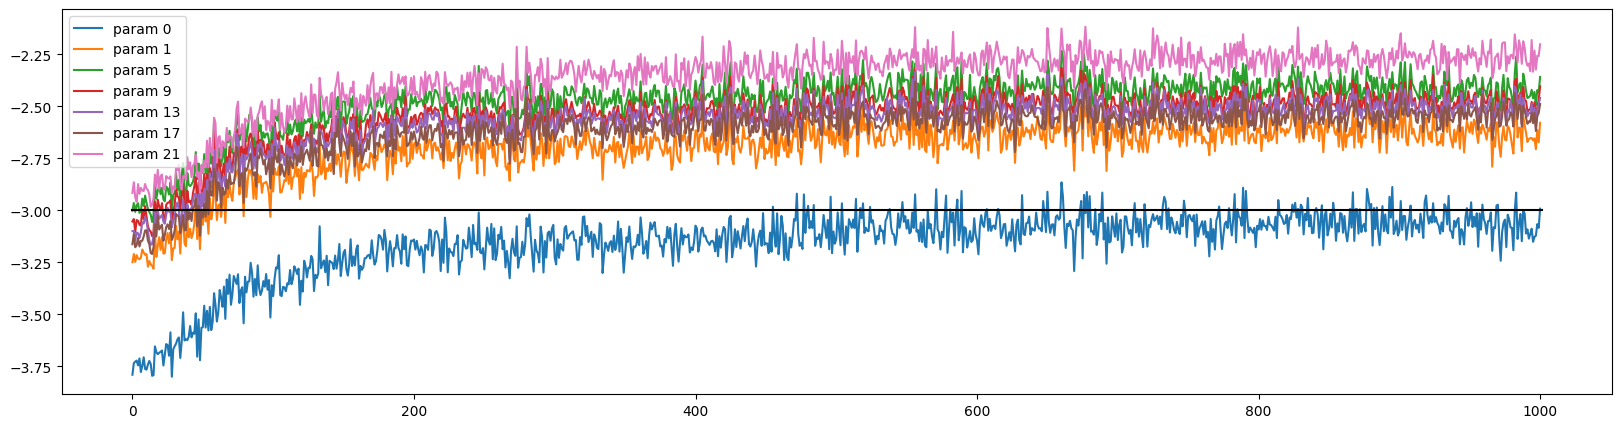

In [58]:
plt.figure(figsize=(20, 5))
legends = []
for i, p in enumerate(parameters): # note: exclude output layer
    if p.ndim == 2:
      plt.plot([ud[j][i] for j in range(len(ud))])
      legends.append('param %d' % (i))
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicated on plot
plt.legend(legends);